In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

#from helper2 import generate_dataset, visualize_one_dataset, visualize_datasets, predict_grid, visualize_predictions
from torch.utils import data

%load_ext autoreload
%autoreload 2

import torchvision

from time import time
from torchvision import datasets, transforms
from torch import nn, optim

from helpers_opt_parameters import *
from sdlbfgs import *
from lbfgsnew import * 

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

### MNIST dataset
The MNIST dataset is loaded.

In [3]:
trainset = datasets.FashionMNIST('', download=True, train=True, transform=transform)
valset = datasets.FashionMNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)

In [4]:
print("Training and test sets information is displayed.\n\n")
print("Trainset:\n",trainset)
print("Testset:\n",valset)

Training and test sets information is displayed.


Trainset:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Testset:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: PATH_TO_STORE_TESTSET
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


# LBFGS mini-batch hyperparameters tuning 



In [14]:
minibatch_size_grid = [32,128,1024,1024]
max_iter_grid = [  3,6,15,25 ]

In [11]:
epochs = 10


In [ ]:
def hyperparameters_tuning_LBFGS_new_minibatch2(trainset, valset, batchsize_grid, max_iter_grid, epochs, model_NN):

    training_loss =[]
    test_loss = []
    training_accuracy = []
    test_accuracy = []
    times = []
    parameters = []
    results = []
    Names = ["training_loss","training_accuracy","test_loss","test_accuracy","times","parameters: batch iter"]
    results.append(Names)
    
    for i in range(len(batchsize_grid)):
        bs = batchsize_grid[i]
        max_iter_ = max_iter_grid[i]
        
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True)
        valloader = torch.utils.data.DataLoader(valset, batch_size=bs, shuffle=True)
        dataiter = iter(trainloader)
        images,_=dataiter.next()
        image_size=images[0].shape[1]
        input_size = int(image_size**2)
        output_size = 10
        
        
        print("Minibatch size: ", bs)
        print("History size: ",max_iter_)
        parameter = []
        if model_NN=="FCNN":
            sizes = [input_size,128,64,output_size]
            model = fully_connected_NN(sizes)
            criterion = nn.NLLLoss()
            optimizer=LBFGSNew(model.parameters(), max_iter=max_iter_, history_size=max_iter_, line_search_fn=True, batch_mode=True)

        elif model_NN=="CNN":
            model=ConvNet(image_size)
            criterion = nn.CrossEntropyLoss()
            optimizer=LBFGSNew(model.parameters(), max_iter=max_iter_, history_size=max_iter_, line_search_fn=True, batch_mode=True)


        if model_NN=="FCNN":
            train_losses, test_losses, train_accuracies, test_accuracies,train_time=optimize(optimizer, epochs, trainloader, valloader, model,criterion,method = "LBFGS")
        elif model_NN=="CNN":
            train_losses, test_losses, train_accuracies, test_accuracies,train_time=optimize_CNN(optimizer, epochs, trainloader, valloader, model,criterion,method = "LBFGS")
             
            # save the parameters 
        parameter = []
        parameter.append(bs)
        parameter.append(max_iter_)
            
        parameters.append(parameter)
        times.append(train_time)
        training_loss.append(train_losses)
        test_loss.append(test_losses)
        training_accuracy.append(train_accuracies)
        test_accuracy.append( test_accuracies )
            
    results.append(training_loss)
    results.append(training_accuracy)
    results.append(test_loss)
    results.append(test_accuracy)
    results.append(times)
    results.append(parameters)

    return  results





### Fully connected network

In [12]:
results = hyperparameters_tuning_LBFGS_new_minibatch2(trainset, valset, batchsize_grid, max_iter_grid, epochs, "FCNN")

Minibatch size:  1024
History size:  10
Epoch 0


KeyboardInterrupt: 

In [25]:
np.savetxt('results/LBFGS_new_minibatch_fcnn_1_trainloss.txt', results[1])
np.savetxt('results/LBFGS_new_minibatch_fcnn_1_testloss.txt', results[3])
np.savetxt('results/LBFGS_new_minibatch_fcnn_1_trainacc.txt', results[2])
np.savetxt('results/LBFGS_new_minibatch_fcnn_1_testacc.txt', results[4])
np.savetxt('results/LBFGS_new_minibatch_fcnn_1_times.txt',results[5])

['training_loss',
 'training_accuracy',
 'test_loss',
 'test_accuracy',
 'times',
 'parameters: batch iter']

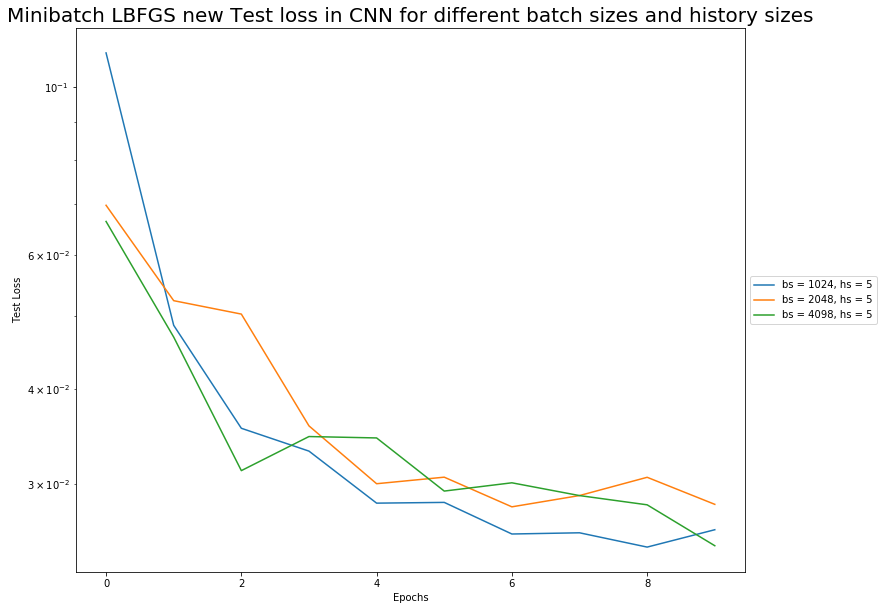

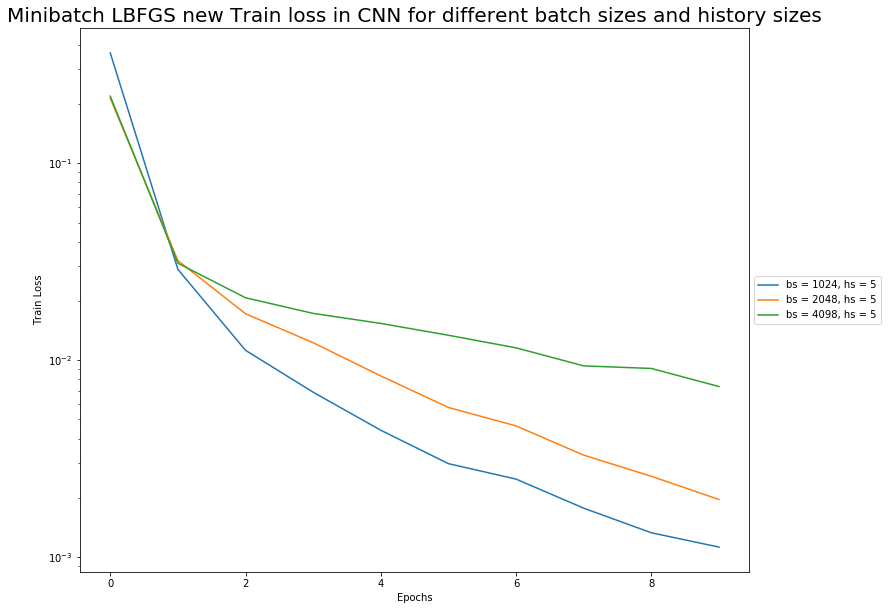

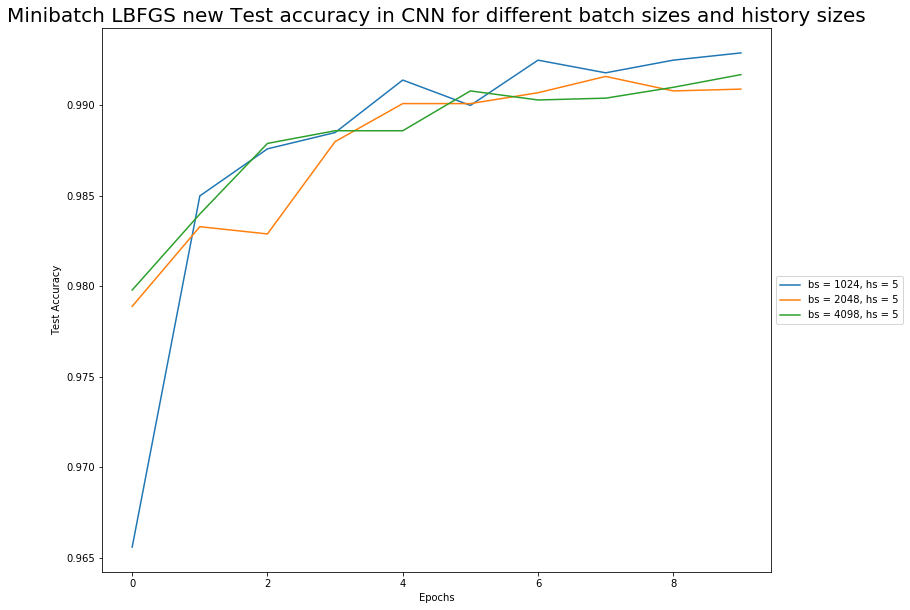

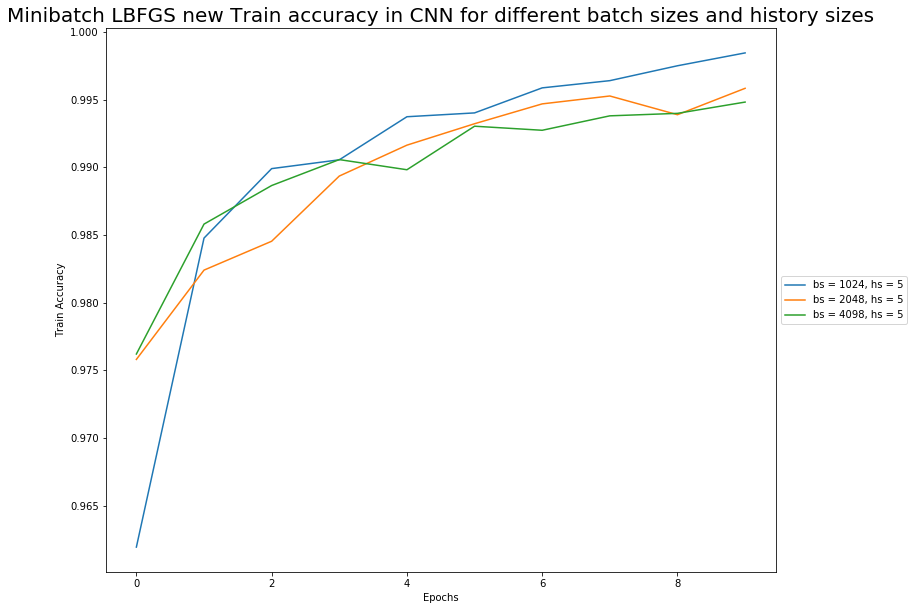

In [15]:
for i in range(len(batchsize_grid)):
        bs = batchsize_grid[i]
        hs = max_iter_grid[i]
        
        plt.figure(1, figsize = (12,10))
        plt.semilogy(results[3][i],label='bs = {}, hs = {}'.format(bs,hs))
        plt.figure(2, figsize = (12,10))
        plt.semilogy(results[1][i],label='bs = {}, hs = {}'.format(bs,hs))
        plt.figure(3, figsize = (12,10))
        plt.plot(results[4][i],label='bs = {}, hs = {}'.format(bs,hs))
        plt.figure(4, figsize = (12,10))
        plt.plot(results[2][i],label='bs = {}, hs = {}'.format(bs,hs))
        
plt.figure(1)
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.title('Minibatch LBFGS new Test loss in FCNN for different batch sizes and history sizes',fontsize = 20)
plt.legend()
plt.savefig("results/mini_LBFGS_new_test_loss_fcnn_1.jpg")
plt.figure (2)
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.title('Minibatch LBFGS new Train loss in FCNN for different batch sizes and history sizes',fontsize = 20)
plt.legend()
plt.savefig("results/mini_LBFGS_new_train_loss_fcnn_1.jpg")
plt.figure (3)
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('Minibatch LBFGS new Test accuracy in FCNN for different batch sizes and history sizes',fontsize = 20)
plt.legend()
plt.savefig("results/mini_LBFGS_new_test_acc_fcnn_1.jpg")
plt.figure (4)
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('Minibatch LBFGS new Train accuracy in FCNN for different batch sizes and history sizes',fontsize = 20)
plt.legend()
plt.savefig("results/mini_LBFGS_new_train_acc_fcnn_1.jpg")


## CNN

In [ ]:
minibatch_size_grid = [1024]
max_iter_grid = [ 5]

In [ ]:
results2 = hyperparameters_tuning_LBFGS_new_minibatch2(trainset, valset, batchsize_grid, max_iter_grid, epochs, "FNN")

In [ ]:
np.savetxt('results/LBFGS_new_minibatch_cnn_1_trainloss.txt', results2[1])
np.savetxt('results/LBFGS_new_minibatch_cnn_1_testloss.txt', results2[3])
np.savetxt('results/LBFGS_new_minibatch_cnn_1_trainacc.txt', results2[2])
np.savetxt('results/LBFGS_new_minibatch_cnn_1_testacc.txt', results2[4])
np.savetxt('results/LBFGS_new_minibatch_cnn_1_times.txt',results2[5])

In [ ]:
for i in range(len(batchsize_grid)):
        bs = batchsize_grid[i]
        hs = max_iter_grid[i]
        
        plt.figure(1, figsize = (12,10))
        plt.semilogy(results2[3][i],label='bs = {}, hs = {}'.format(bs,hs))
        plt.figure(2, figsize = (12,10))
        plt.semilogy(results2[1][i],label='bs = {}, hs = {}'.format(bs,hs))
        plt.figure(3, figsize = (12,10))
        plt.plot(results2[4][i],label='bs = {}, hs = {}'.format(bs,hs))
        plt.figure(4, figsize = (12,10))
        plt.plot(results2[2][i],label='bs = {}, hs = {}'.format(bs,hs))
        
plt.figure(1)
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.title('Minibatch LBFGS new Test loss in CNN for different batch sizes and history sizes',fontsize = 20)
plt.legend()
plt.savefig("results/mini_LBFGS_new_test_loss_cnn_1.jpg")
plt.figure (2)
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.title('Minibatch LBFGS new Train loss in CNN for different batch sizes and history sizes',fontsize = 20)
plt.legend()
plt.savefig("results/mini_LBFGS_new_train_loss_cnn_1.jpg")
plt.figure (3)
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('Minibatch LBFGS new Test accuracy in CNN for different batch sizes and history sizes',fontsize = 20)
plt.legend()
plt.savefig("results/mini_LBFGS_new_test_acc_cnn_1.jpg")
plt.figure (4)
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('Minibatch LBFGS new Train accuracy in CNN for different batch sizes and history sizes',fontsize = 20)
plt.legend()
plt.savefig("results/mini_LBFGS_new_train_acc_cnn_1.jpg")

